## 1. Import Required Libraries

In [1]:
import math
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from typing import Tuple
from tqdm.auto import tqdm

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent.parent))

from hira.index import KMeansIndex, KMeansIndexConfig, Index
from hira.search import HalfspaceSearcher

from line_profile_benchmark import generate_data

# Force single-threaded execution for consistent benchmarking
torch.set_num_threads(1)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Libraries imported successfully!


/home/mohsen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration and Setup

In [2]:
# Experiment configuration
CONFIG = {
    "num_keys_list": [10000, 20000, 40000, 50000, 60000, 100000],
    "branching_factors": [4, 8, 16, 32, 64, 128],
    "distributions": ["real"],  # , "uniform", "mixture_of_gaussians", "zipf"],
    "dim": 128,
    "device": "cpu",
    "target_results": 10,
    "max_iterations": 1,
    "seed": 42,
    "num_runs": 5,  # Number of times to run each experiment
    "real_data_path": "/home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz",
    "output_csv": "benchmark_results.csv",
}

# Results storage
results = []

## Search Function Implementations

In [3]:
def brute_force_search(
    index: Index, query: torch.Tensor, threshold: float
) -> torch.Tensor:
    """Brute-force search."""
    # query_norm = query / torch.norm(query, p=2)
    scores = torch.matmul(index.keys, query)
    result = (scores >= threshold).nonzero(as_tuple=True)[0]
    return result


def indexed_search(index: Index, query: torch.Tensor, threshold: float) -> torch.Tensor:
    """Indexed search using HalfspaceSearcher."""
    searcher = HalfspaceSearcher(enable_profiling=False)
    result = searcher.search(query, threshold, index)
    return result


def run_benchmark(
    keys: torch.Tensor,
    branching_factor: int,
    dim: int,
    device: str,
    max_iterations: int,
    target_results: int,
    num_runs: int = 5,
) -> Tuple[float, float, float, float, int, int]:
    """Run a single benchmark multiple times and return average timings with std dev."""
    keys = keys.to(device)

    # Calculate number of levels
    num_levels = math.ceil(math.log(len(keys)) / math.log(branching_factor))

    # Build index (only once)
    config = KMeansIndexConfig(
        num_levels=num_levels,
        branching_factor=branching_factor,
        max_iterations=max_iterations,
        device=device,
    )
    index = KMeansIndex(config)
    index.build(keys)

    # Create query and find threshold (only once)
    query = torch.randn(dim).to(device)
    query_norm = query / torch.norm(query, p=2)
    all_scores = torch.matmul(keys, query_norm)
    sorted_scores, _ = torch.sort(all_scores, descending=True)
    threshold = sorted_scores[min(target_results, len(sorted_scores) - 1)].item()

    # Run multiple times
    bf_times = []
    indexed_times = []
    bf_count = 0
    indexed_count = 0

    for _ in range(num_runs):
        # Time brute-force search
        start_time = time.time()
        result_bf = brute_force_search(index, query, threshold)
        bf_times.append(time.time() - start_time)
        bf_count = len(result_bf)

        # Time indexed search
        start_time = time.time()
        result_indexed = indexed_search(index, query, threshold)
        indexed_times.append(time.time() - start_time)
        indexed_count = len(result_indexed)

    # Calculate averages and standard deviations
    bf_time_mean = np.mean(bf_times)
    bf_time_std = np.std(bf_times)
    indexed_time_mean = np.mean(indexed_times)
    indexed_time_std = np.std(indexed_times)

    return (
        bf_time_mean,
        bf_time_std,
        indexed_time_mean,
        indexed_time_std,
        bf_count,
        indexed_count,
    )


print("Search functions defined!")

Search functions defined!


## Run Benchmark Experiments

### Load Existing Results (Optional)

In [16]:
# # Uncomment to load existing results instead of running experiments
# output_csv = Path(CONFIG["output_csv"])
# if output_csv.exists():
#     df_results = pd.read_csv(output_csv)
#     print(f"✓ Loaded {len(df_results)} results from {output_csv.absolute()}")
#     print(f"  Columns: {list(df_results.columns)}")
#     print(f"  Distributions: {df_results['distribution'].unique()}")
#     print(f"  Key counts: {sorted(df_results['num_keys'].unique())}")
#     print(f"  Branching factors: {sorted(df_results['branching_factor'].unique())}")
# else:
#     print(f"No existing results found at {output_csv.absolute()}")

✓ Loaded 24 results from /home/mohsen/kvcache/hira/tests/indexes_benchmark/benchmark_results.csv
  Columns: ['distribution', 'num_keys', 'branching_factor', 'brute_force_time_mean', 'brute_force_time_std', 'indexed_time_mean', 'indexed_time_std', 'speedup', 'bf_count', 'indexed_count', 'num_runs']
  Distributions: ['real']
  Key counts: [10000, 20000, 40000, 50000, 60000, 100000]
  Branching factors: [4, 8, 16, 32]


In [ ]:
%%time

results = []
output_csv = Path(CONFIG['output_csv'])

# Calculate total experiments
total_experiments = len(CONFIG['distributions']) * len(CONFIG['num_keys_list']) * len(CONFIG['branching_factors'])

# Create overall progress bar
overall_pbar = tqdm(total=total_experiments, desc="Overall Progress", position=0, leave=True)

for distribution in CONFIG['distributions']:
    for num_keys in CONFIG['num_keys_list']:
        print(f"\n  Keys: {num_keys:,}")
        
        # Generate data once for this num_keys
        keys = generate_data(
            num_keys,
            CONFIG['dim'],
            distribution=distribution,
            seed=CONFIG['seed'],
            real_data_path=CONFIG['real_data_path']
        )
        
        # Create progress bar for branching factors
        bf_pbar = tqdm(
            CONFIG['branching_factors'], 
            desc=f"    BF Progress", 
            position=1,
            leave=False
        )
        
        for branching_factor in bf_pbar:
            bf_pbar.set_description(f"    BF={branching_factor:2d}")
            
            try:
                bf_time_mean, bf_time_std, indexed_time_mean, indexed_time_std, bf_count, indexed_count = run_benchmark(
                    keys,
                    branching_factor,
                    CONFIG['dim'],
                    CONFIG['device'],
                    CONFIG['max_iterations'],
                    CONFIG['target_results'],
                    CONFIG['num_runs']
                )
                
                speedup = bf_time_mean / indexed_time_mean if indexed_time_mean > 0 else 0
                
                result = {
                    'distribution': distribution,
                    'num_keys': num_keys,
                    'branching_factor': branching_factor,
                    'brute_force_time_mean': bf_time_mean,
                    'brute_force_time_std': bf_time_std,
                    'indexed_time_mean': indexed_time_mean,
                    'indexed_time_std': indexed_time_std,
                    'speedup': speedup,
                    'bf_count': bf_count,
                    'indexed_count': indexed_count,
                    'num_runs': CONFIG['num_runs']
                }
                
                results.append(result)
                
                # Update progress bar with stats
                bf_pbar.set_postfix({
                    'BF_ms': f"{bf_time_mean*1000:.2f}±{bf_time_std*1000:.2f}",
                    'Idx_ms': f"{indexed_time_mean*1000:.2f}±{indexed_time_std*1000:.2f}",
                    'Speedup': f"{speedup:.2f}x"
                })
                
            except Exception as e:
                print(f"\n    ERROR at BF={branching_factor}: {str(e)}")
                results.append({
                    'distribution': distribution,
                    'num_keys': num_keys,
                    'branching_factor': branching_factor,
                    'brute_force_time_mean': None,
                    'brute_force_time_std': None,
                    'indexed_time_mean': None,
                    'indexed_time_std': None,
                    'speedup': None,
                    'bf_count': None,
                    'indexed_count': None,
                    'num_runs': CONFIG['num_runs']
                })
            
            # Update overall progress
            overall_pbar.update(1)
            
            # Save intermediate results to CSV after each experiment
            pd.DataFrame(results).to_csv(output_csv, index=False)

overall_pbar.close()

# Convert to DataFrame
df_results = pd.DataFrame(results)

print(f"\nTotal results: {len(df_results)}")
print(f"Successful: {df_results['speedup'].notna().sum()}")
print(f"Failed: {df_results['speedup'].isna().sum()}")
print(f"\nResults saved to: {output_csv.absolute()}")

## 8. Visualization: Speedup Analysis

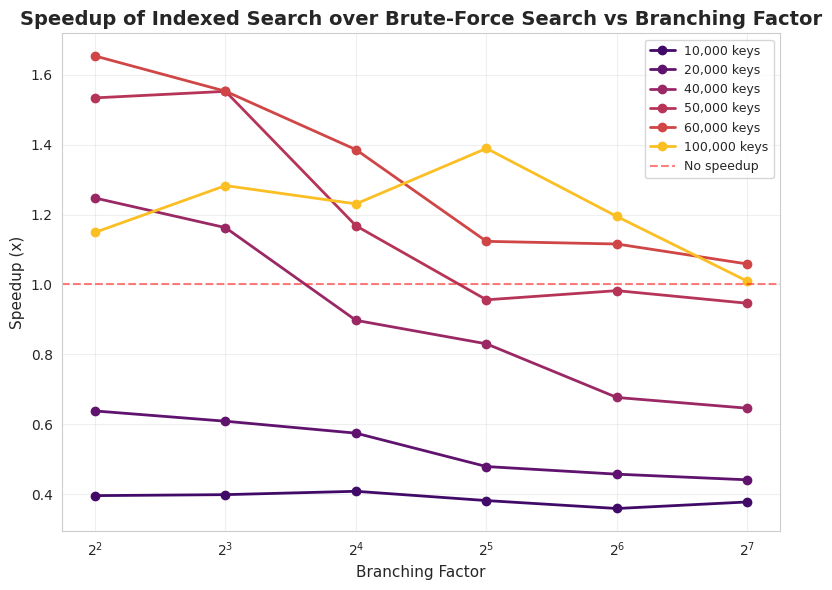

In [7]:
# fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# fig.suptitle(
#     "Speedup (Brute Force / Indexed) vs Branching Factor",
#     fontsize=16,
#     fontweight="bold",
# )
plt.figure(figsize=(8, 6))
from matplotlib.colors import LinearSegmentedColormap

# Define key counts and create a gray-to-black color map
key_counts = [10000, 20000, 40000, 50000, 60000, 100000]

base = plt.cm.inferno
cmap = LinearSegmentedColormap.from_list(
    "inferno_dark", base(np.linspace(0.2, 0.85, 256))
)

norm = plt.Normalize(vmin=min(key_counts), vmax=max(key_counts))

df_dist = df_results

# Plot speedup for different number of keys with gray-to-black color scale
for num_keys in key_counts:
    if num_keys in df_dist["num_keys"].values:
        df_nk = df_dist[df_dist["num_keys"] == num_keys]
        color = cmap(norm(num_keys))
        plt.plot(
            df_nk["branching_factor"],
            df_nk["speedup"],
            marker="o",
            linestyle="-",
            color=color,
            linewidth=2,
            label=f"{num_keys:,} keys",
        )

plt.axhline(y=1, color="red", linestyle="--", alpha=0.5, label="No speedup")
plt.xlabel("Branching Factor", fontsize=11)
plt.ylabel("Speedup (x)", fontsize=11)
plt.title(
    "Speedup of Indexed Search over Brute-Force Search vs Branching Factor",
    fontsize=14,
    fontweight="bold",
)
plt.xscale("log", base=2)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig("benchmark_speedup_vs_branching_factor.png", dpi=300)
plt.show()

## 9. Visualization: Average Execution Times

## 10. Visualization: Best Performance vs Number of Keys

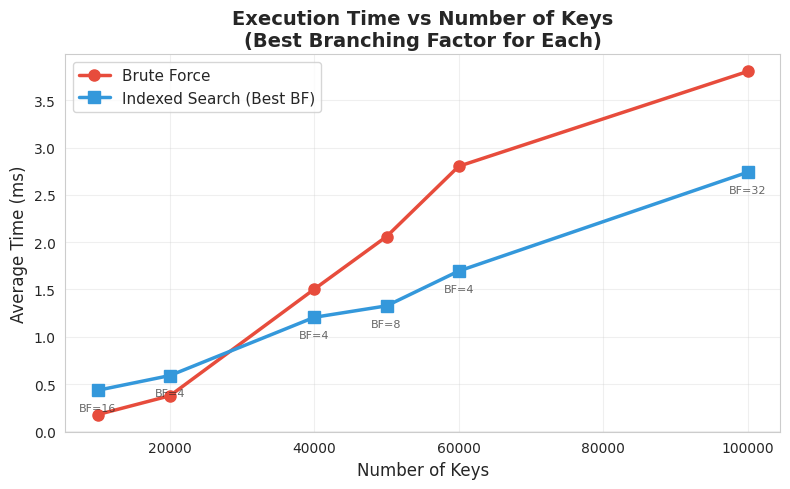

In [ ]:
plt.figure(figsize=(8, 5))

# For each num_keys, find the branching factor with the highest speedup
best_results = []
for num_keys in sorted(df_results["num_keys"].unique()):
    df_nk = df_results[df_results["num_keys"] == num_keys]
    # Find row with maximum speedup
    best_row = df_nk.loc[df_nk["speedup"].idxmax()]
    best_results.append(
        {
            "num_keys": num_keys,
            "branching_factor": best_row["branching_factor"],
            "brute_force_time": best_row["brute_force_time_mean"]
            * 1000,  # Convert to ms
            "indexed_time": best_row["indexed_time_mean"] * 1000,  # Convert to ms
            "speedup": best_row["speedup"],
        }
    )

df_best = pd.DataFrame(best_results)

# Plot both lines
plt.plot(
    df_best["num_keys"],
    df_best["brute_force_time"],
    marker="o",
    linestyle="-",
    linewidth=2.5,
    markersize=8,
    color="#e74c3c",
    label="Brute Force",
)

plt.plot(
    df_best["num_keys"],
    df_best["indexed_time"],
    marker="s",
    linestyle="-",
    linewidth=2.5,
    markersize=8,
    color="#3498db",
    label="Indexed Search (Best BF)",
)

plt.xlabel("Number of Keys", fontsize=12)
plt.ylabel("Average Time (ms)", fontsize=12)
plt.title(
    "Execution Time vs Number of Keys\n(Best Branching Factor for Each)",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
# plt.yscale("log")

# Add annotations for branching factors
for idx, row in df_best.iterrows():
    plt.annotate(
        f"BF={int(row['branching_factor'])}",
        xy=(row["num_keys"], row["indexed_time"]),
        xytext=(0, -15),
        textcoords="offset points",
        fontsize=8,
        ha="center",
        alpha=0.7,
    )

plt.tight_layout()
# plt.savefig("benchmark_best_speed_vs_num_keys.png", dpi=300)
plt.show()